# Multivariate to each input/output Time Series

In [39]:
import numpy as np
import time
import math
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error

import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters
# https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/
# https://www.gritfeat.com/explainable-aixai-from-correlation-to-causation-shap-for-lstm-time-series-model/
#http://localhost:8888/lab/tree/MyQuantFinProject/TimeSeriesML-FinMarket/Nachiketa-Hebbar-LSTM/RNN_Youtube.ipynb

In [ ]:
ab_path = "../data/SET50-Daily-Y09-Now.csv"
stockname='S&P500'
start_date='2012-01-01'
end_date='2022-12-31'

# EMA2 and Signal
prediction_col='Price'
my_features=['Price', 'EMA1','EMA2','EMA3','MACD', 'SIGNAL', 'RSI','RSI-MA']
#my_features=['Price', 'EMA1','EMA2','MACD', 'SIGNAL', 'RSI','RSI-MA']
# each feature predict itself

n_early=6

train_ratio=0.8


n_batch=32
n_epochs=100


n_input =60
# define generator

n_features = len(my_features)
print(f"input={n_input} and features={n_features}")

tune_folder='multivar_tune'


seed=7


# Load Data

In [ ]:
df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
df.rename(columns={'Date/Time':'Date'},inplace=True)
allCols=list(df.columns)
print(allCols)

df['Date']=df['Date'].apply( lambda  dx :  datetime(dx.year,dx.month,dx.day ))
df.set_index('Date',inplace=True)
df=df.loc[start_date:end_date][my_features]
print(df.info())
print(df.tail(3))



# Tranform Data

In [49]:
print("Tranform Data")
dfValues=df.values
print(dfValues.shape)
train_data_len = math.ceil(len(dfValues) * train_ratio)
print(f"{train_ratio} of {len(dfValues)} = The number of train data is {train_data_len}")
train_values = dfValues[0:train_data_len]
test_values = dfValues[train_data_len:]
print(train_values.shape,test_values.shape)
    
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
scaler = MinMaxScaler()
#scaler= PowerTransformer()
scaler.fit(train_values)
train = scaler.transform(train_values)
test = scaler.transform(test_values)

print(train.shape,test.shape)
print(type(train),type(test))
print(train[-2:])
print(test[-2:])

Tranform Data
(2680, 8)
0.8 of 2680 = The number of train data is 2144
(2144, 8) (536, 8)
(2144, 8) (536, 8)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[0.22301611 0.14953411 0.18125389 0.18125389 0.62590851 0.58775685
  0.35457362 0.23035191]
 [0.23732517 0.15430031 0.18146867 0.18146867 0.64856776 0.59232306
  0.405227   0.26583578]]
[[0.62731833 0.5735111  0.57303636 0.57303636 0.78698162 0.76013128
  0.7235619  0.57815249]
 [0.61791198 0.57937224 0.57688095 0.57688095 0.79702864 0.76783676
  0.65539539 0.62903226]]


# Generate Timeseries For LSTM

In [50]:
# each feature predict itself
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)
n_output=len(my_features)

# each feature predict one output , 0=close is targer 
# generator = TimeseriesGenerator(train,train[:,0], length=n_input, batch_size=1)
# n_output=1

# number of samples
print(f'Samples: {len(generator)}')
# print each sample
for i in range(len(generator)):
 x, y = generator[i]
 if i<=1:
    # n_output=y.shape[1]
    # print("Output: ",n_output)
    print(x.shape,y.shape)  
    print(f'{x} => {y}')
    print("=========================")
    


Samples: 2084
(1, 60, 8) (1, 8)
[[[0.08916084 0.         0.         0.         0.78345447 0.84460616
   0.56459652 0.51085044]
  [0.08940787 0.00156726 0.00154642 0.00154642 0.78366823 0.83961187
   0.56553954 0.5186217 ]
  [0.08669048 0.00229722 0.00264181 0.00264181 0.78174434 0.83490297
   0.54950829 0.52316716]
  [0.09908027 0.00543175 0.00496145 0.00496145 0.7858059  0.83147831
   0.60204769 0.5483871 ]
  [0.11032989 0.01030529 0.00829056 0.00829056 0.7935015  0.82976598
   0.6447528  0.58093842]
  [0.10654834 0.0135257  0.01088941 0.01088941 0.79660111 0.82876712
   0.62023441 0.59296188]
  [0.10605427 0.01605908 0.01318757 0.01318757 0.79777683 0.82819635
   0.6168665  0.60410557]
  [0.09564077 0.01599468 0.01415408 0.01415408 0.79264643 0.82676941
   0.54829584 0.60381232]
  [0.08429614 0.01359011 0.01378896 0.01378896 0.78249252 0.82377283
   0.48107234 0.57756598]
  [0.11394041 0.01773369 0.01666702 0.01666702 0.78879863 0.82234589
   0.60824465 0.56964809]
  [0.1069284  0.01

# LSTM Train

In [51]:
#neuron_number=100

np.random.seed(7)



In [52]:
#1 feature  to predict  1 output
print("Get n_input to set step for neuron")
neuron_number=n_input
step_neuron=int(neuron_number/1)
max_neuron=step_neuron*5
print(f"{neuron_number}= {n_input} (univariate n_features=1) with step {step_neuron} until {max_neuron}")

min_drop=0.1
max_drop=0.3
step_drop=0.1

ratio_traial_max=0.7  # 0.6/0.7

neuron_list = [*range(neuron_number, max_neuron+step_neuron, step_neuron)]

drop_list=np.arange (min_drop, max_drop ,step_drop)
drop_list=np.append(drop_list,[max_drop])

allPosComb=len(neuron_list)*len(drop_list)
print(f"{neuron_list} and {drop_list}")
print(f"all combination : {len(neuron_list)} x {len(drop_list)} = {allPosComb}")

nMax_trials=int(allPosComb*ratio_traial_max)
nExecutions_per_trial=3

print(nMax_trials , "each trail run to essemble ",nExecutions_per_trial)



Get n_input to set step for neuron
60= 60 (univariate n_features=1) with step 60 until 300
[60, 120, 180, 240, 300] and [0.1 0.2 0.3]
all combination : 5 x 3 = 15
10 each trail run to essemble  3


In [53]:
def my_model(neuron_number,dropout_rate):   

 model = Sequential()

 model.add(LSTM(units=neuron_number, activation='relu',return_sequences=False, input_shape=(n_input, n_features))) 
 model.add(Dropout(dropout_rate))   

 model.add(Dense(n_output))

#https://keras.io/api/metrics/
 model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])

 return model


def build_hp_model(hp):
    x_neuron_number=hp.Int('input_unit',min_value=neuron_number ,max_value=max_neuron,step=step_neuron)
    x_dropout_rate=hp.Float('Dropout_rate',min_value=min_drop,max_value=max_drop,step=step_drop)
    
    model=my_model( x_neuron_number, x_dropout_rate)

    return model

build_hp_model(kt.HyperParameters())


In [54]:
t_Start=time.time()

print(f"Start tund at {datetime.now()}")

buildtime = datetime.now().strftime('%d%m%y_%H%M')
project_model=f"multi_inout_bayesian{buildtime}"
print(project_model)

Start tund at 2023-01-06 14:49:37.252069
multi_inout_bayesian060123_1449


In [ ]:
tuner = kt.BayesianOptimization(
# tuner = kt.Hyperband(
# tuner= kt.RandomSearch(
        build_hp_model,
        objective='mse',
        max_trials=nMax_trials,
        seed=seed,
        executions_per_trial=nExecutions_per_trial,
        directory=f"{tune_folder}/",
        project_name= project_model   
        )

if (n_early>0):
 early_stop = EarlyStopping(monitor='loss', patience=n_early, verbose=1)
 tuner.search(generator, batch_size=n_batch, epochs=n_epochs,
                        shuffle=False,verbose=1,callbacks=[early_stop])
else:
 tuner.search(generator, batch_size=n_batch, epochs=n_epochs,
                        shuffle=False,verbose=1)   

print("Space to seachr")
tuner.search_space_summary()
print(f"Suumary of {max_trials}")
tuner.results_summary()


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
120               |?                 |input_unit
0.1               |?                 |Dropout_rate

Epoch 1/100
2084/2084 [==============================] - 59s 26ms/step - loss: 0.0092 - mse: 0.0092
Epoch 2/100
2084/2084 [==============================] - 53s 26ms/step - loss: 0.0067 - mse: 0.0067
Epoch 3/100
2084/2084 [==============================] - 53s 26ms/step - loss: 0.0056 - mse: 0.0056
Epoch 4/100
 422/2084 [=====>........................] - ETA: 26s - loss: 0.0048 - mse: 0.0048

In [ ]:
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execution : ',round(t_elapsed,2)) 
print(datetime.now())

# Query the results

In [27]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print("Show best hyperparamter values")
print(best_hps.values)
best_model=tuner.get_best_models(num_models=1)[0]
best_model.summary()



Show best hyperparamter values
{'input_unit': 60, 'Dropout_rate': 0.0}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60)                16560     
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 8)                 488       
                                                                 
Total params: 17,048
Trainable params: 17,048
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Build the model with the best hp for test all data.
# print("[INFO] training the best model...")
# #model = tuner.hypermodel.build(best_hps)

# model = build_hp_model(best_hps)
# model.summary()

model=tuner.get_best_models(num_models=1)[0]

In [29]:
#history=model.fit_generator(generator, steps_per_epoch=1, epochs=n_epochs, verbose=0)

# # Fit with the entire dataset.
# x_all = np.concatenate((x_train, x_val))
# y_all = np.concatenate((y_train, y_val))
# model.fit(x=x_all, y=y_all, epochs=1)

history=model.fit(generator,epochs=n_epochs,batch_size=n_batch,shuffle=False)

Epoch 1/100
2084/2084 [==============================] - 30s 14ms/step - loss: 6.5201e-04 - mse: 6.5201e-04
Epoch 2/100
2084/2084 [==============================] - 29s 14ms/step - loss: 6.6999e-04 - mse: 6.6999e-04
Epoch 3/100
2084/2084 [==============================] - 29s 14ms/step - loss: 7.0313e-04 - mse: 7.0313e-04
Epoch 4/100
2084/2084 [==============================] - 29s 14ms/step - loss: 8.5752e-04 - mse: 8.5752e-04
Epoch 5/100
2084/2084 [==============================] - 29s 14ms/step - loss: 0.0011 - mse: 0.0011
Epoch 6/100
2084/2084 [==============================] - 28s 14ms/step - loss: 8.0957e-04 - mse: 8.0957e-04
Epoch 7/100
2084/2084 [==============================] - 29s 14ms/step - loss: 7.1279e-04 - mse: 7.1279e-04
Epoch 8/100
2084/2084 [==============================] - 28s 14ms/step - loss: 7.3259e-04 - mse: 7.3259e-04
Epoch 9/100
2084/2084 [==============================] - 28s 14ms/step - loss: 8.0716e-04 - mse: 8.0716e-04
Epoch 10/100
2084/2084 [============

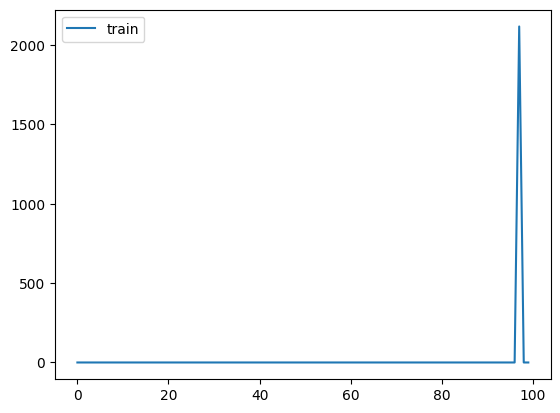

In [30]:
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

# Get Test Data(Unseen) by include {n_input_lookback} to predict

# Set Test data for prediction

In [31]:
# test_arr will get start with the last n look back to predict
idx_train_to_test=len(dfValues)-len(test_values)-n_input
print("The first train data to predict the frist test :",idx_train_to_test)



The first train data to predict the frist test : 2084


In [32]:
test_arr=dfValues[idx_train_to_test:]
print(f"Get Test Data {len(test_values)} + {n_input} to predict = {test_arr.shape}")
print(test_arr.shape)
test_scaled_arr=scaler.fit_transform(test_arr)
print(test_scaled_arr.shape)
print(test_scaled_arr[:2])


Get Test Data 536 + 60 to predict = (596, 8)
(596, 8)
(596, 8)
[[0.48139326 0.52048111 0.51876828 0.51876828 0.28277236 0.3448468
  0.38484476 0.45602882]
 [0.45702154 0.50803737 0.51129347 0.51129347 0.2506643  0.33342618
  0.34327311 0.40983259]]


In [33]:
#No.row = len(test_arr)-n_hop_lookback  , we will start triaing at the first rows since n_hop
X_test=[]
for i in range(n_input,test_scaled_arr.shape[0]):
   X_test.append(test_scaled_arr[i-n_input:i]) 
X_test=np.array(X_test)
print(X_test.shape)
print(X_test[:2])

(536, 60, 8)
[[[0.48139326 0.52048111 0.51876828 0.51876828 0.28277236 0.3448468
   0.38484476 0.45602882]
  [0.45702154 0.50803737 0.51129347 0.51129347 0.2506643  0.33342618
   0.34327311 0.40983259]
  [0.45867854 0.49812777 0.50467176 0.50467176 0.22874225 0.31977716
   0.34695667 0.36554355]
  [0.49268158 0.49684179 0.50251869 0.50251869 0.23294951 0.30835655
   0.42203122 0.35473617]
  [0.47259044 0.49177352 0.49829379 0.49829379 0.22630647 0.29749304
   0.3834415  0.33206188]
  [0.50341756 0.49374031 0.49792818 0.49792818 0.23981399 0.28997214
   0.45009647 0.34795508]
  [0.49634079 0.49396725 0.49683133 0.49683133 0.24712135 0.28467967
   0.43536222 0.37020555]
  [0.54525684 0.50387685 0.50129997 0.50129997 0.28100089 0.28523677
   0.53569549 0.41576605]
  [0.49440762 0.50187223 0.49963438 0.49963438 0.27812223 0.28523677
   0.42992457 0.41767324]
  [0.49861917 0.50107795 0.49861878 0.49861878 0.27900797 0.28551532
   0.43869497 0.43102352]
  [0.44614747 0.48995802 0.49183458 0.

# Prediction

In [34]:
y_test_scaled_pred=model.predict(X_test)
print("Before Invert :",y_test_scaled_pred.shape)
y_test_scaled_pred[:3]

17/17 [==============================] - 1s 14ms/step
Before Invert : (536, 8)


array([[0.13753332, 0.09701601, 0.20914763, 0.17820643, 0.3095596 ,
        0.05130988, 0.32516947, 0.21162495],
       [0.16103855, 0.10220207, 0.20092537, 0.17200632, 0.38308224,
        0.10201222, 0.3551571 , 0.25341994],
       [0.1915135 , 0.1123068 , 0.19558208, 0.1690477 , 0.4675773 ,
        0.15931247, 0.38436168, 0.29162115]], dtype=float32)

In [35]:
y_test_pred=scaler.inverse_transform(y_test_scaled_pred)
print("After Invert :" ,y_test_pred.shape)
y_test_pred[:3]

After Invert : (536, 8)


array([[ 7.8610065e+02,  7.8483008e+02,  8.2183380e+02,  8.1421729e+02,
        -5.0287858e-02, -9.8979759e+00,  4.2497913e+01,  3.9716579e+01],
       [ 7.9290961e+02,  7.8620117e+02,  8.1980981e+02,  8.1269110e+02,
         3.2699940e+00, -8.0777617e+00,  4.4207508e+01,  4.1688889e+01],
       [ 8.0173767e+02,  7.8887280e+02,  8.1849451e+02,  8.1196277e+02,
         7.0857911e+00, -6.0206823e+00,  4.5872459e+01,  4.3491604e+01]],
      dtype=float32)

# Create Predction DataFrame and Measure and Plot Chart

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price        536 non-null    float64
 1   Price-Pred   536 non-null    float32
 2   EMA1         536 non-null    float64
 3   EMA1-Pred    536 non-null    float32
 4   EMA2         536 non-null    float64
 5   EMA2-Pred    536 non-null    float32
 6   EMA3         536 non-null    float64
 7   EMA3-Pred    536 non-null    float32
 8   MACD         536 non-null    float64
 9   MACD-Pred    536 non-null    float32
 10  SIGNAL       536 non-null    float64
 11  SIGNAL-Pred  536 non-null    float32
 12  RSI          536 non-null    float64
 13  RSI-Pred     536 non-null    float32
 14  RSI-MA       536 non-null    float64
 15  RSI-MA-Pred  536 non-null    float32
dtypes: float32(8), float64(8)
memory usage: 50.4 KB
None


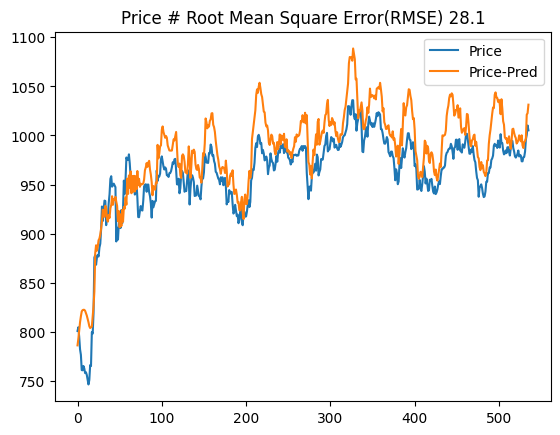

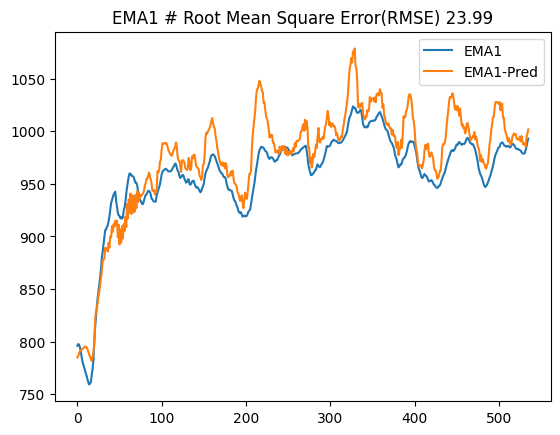

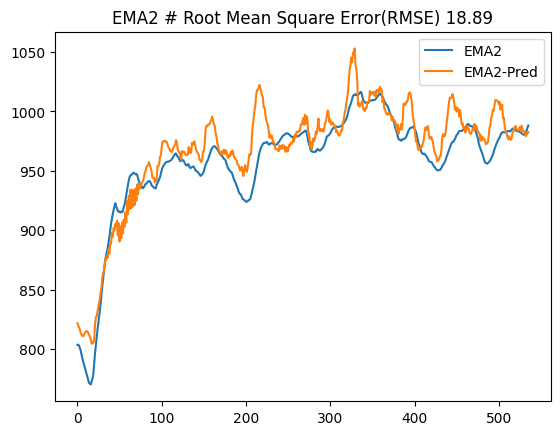

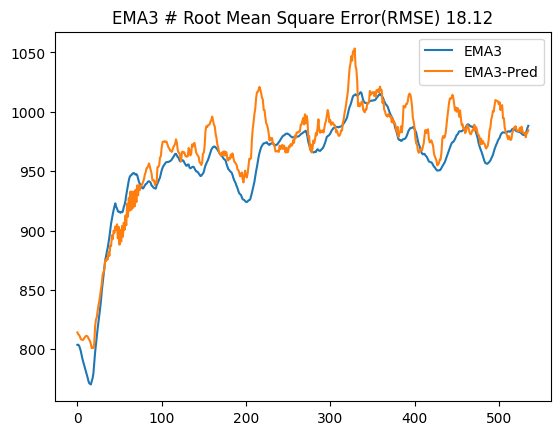

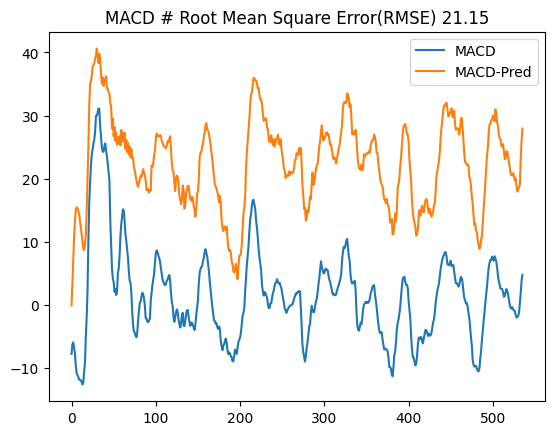

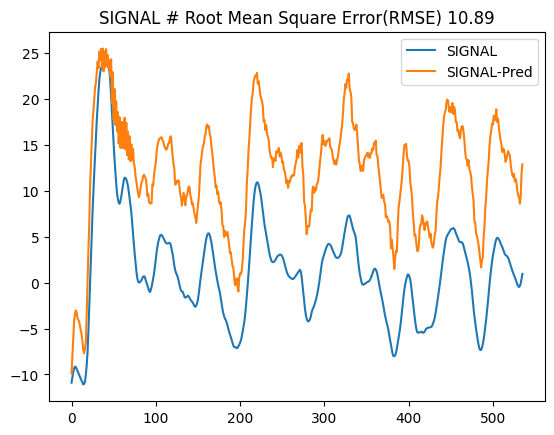

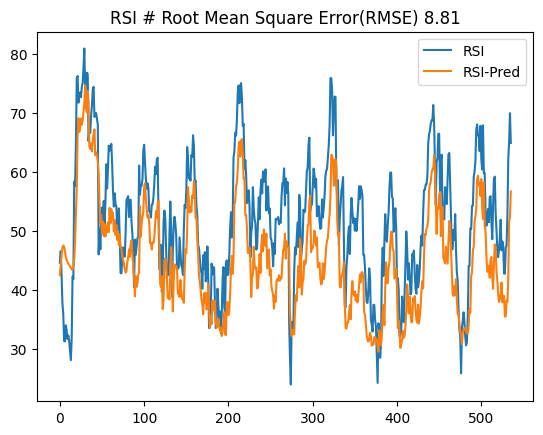

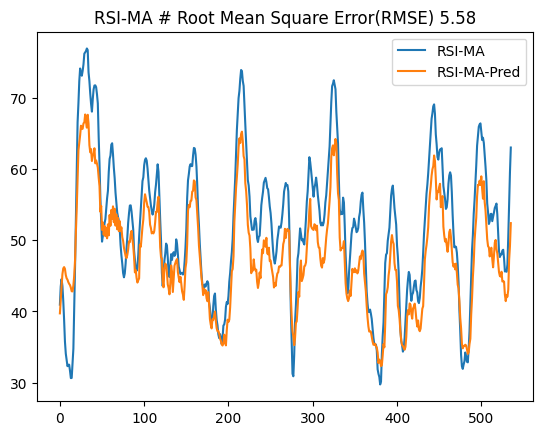

In [37]:
test_df=pd.DataFrame()
listColPair=[]
for i in range(0,len(my_features)): 
  dfActual=pd.DataFrame(data={my_features[i]:test_values[:,i]})  
  dfPred=pd.DataFrame(data={f'{my_features[i]}-Pred':y_test_pred[:,i]})
  listColPair.append([my_features[i],f'{my_features[i]}-Pred'])
  test_df=pd.concat([test_df,dfActual,dfPred],axis=1)
print(test_df.info())

#fig, axs = plt.subplots(nrows=len(listColPair), ncols=1, figsize=(14, 5*len(listColPair)))
for colPair in listColPair:
  rmse = np.sqrt(mean_squared_error(test_df[colPair[0]], test_df[colPair[1]]))
  title=f'{colPair[0]} # Root Mean Square Error(RMSE) {round(rmse,2)}'
  test_df[colPair].plot(title=title)
  plt.legend()
  plt.show()

# Predict One Value

In [38]:
print(f"We will use the last {n_input} data to predict the new one")
last_train_batch=train[-n_input:]
print(last_train_batch.shape,last_train_batch)

print("We need reshape first")
last_train_batch =last_train_batch .reshape((1,n_input,n_features))
print(last_train_batch.shape,last_train_batch)

print("Predict")
last_predict=model.predict(last_train_batch)
print(last_predict)

last_predict = scaler.inverse_transform(last_predict)
print(last_predict.shape,last_predict)


We will use the last 60 data to predict the new one
(60, 8) [[0.39077227 0.37290137 0.38332009 0.38332009 0.73236426 0.76341324
  0.39903004 0.45659824]
 [0.37735634 0.36583795 0.37936811 0.37936811 0.71686618 0.75756279
  0.36710225 0.42463343]
 [0.37826847 0.36021298 0.37586718 0.37586718 0.70628474 0.75057078
  0.36993129 0.39398827]
 [0.39698617 0.35948302 0.37472884 0.37472884 0.70831552 0.74472032
  0.42758992 0.38651026]
 [0.38592657 0.35660612 0.37249511 0.37249511 0.70510902 0.73915525
  0.39795231 0.37082111]
 [0.40289602 0.35772253 0.37230181 0.37230181 0.7116289  0.73530251
  0.44914455 0.38181818]
 [0.39900046 0.35785135 0.3717219  0.3717219  0.71515605 0.73259132
  0.43782837 0.39721408]
 [0.42592733 0.36347632 0.37408449 0.37408449 0.73150919 0.73287671
  0.51488616 0.428739  ]
 [0.3979363  0.36233844 0.37320389 0.37320389 0.73011971 0.73287671
  0.43365216 0.43005865]
 [0.40025464 0.36188759 0.37266694 0.37266694 0.73054724 0.73301941
  0.44038798 0.43929619]
 [0.371370